In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score,KFold,train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [16]:
df_raw = pd.read_csv("datasets/extracted_audio_features.csv")

In [17]:
df_raw.isna().value_counts()

MFCC_1  MFCC_2  MFCC_3  MFCC_4  MFCC_5  MFCC_6  MFCC_7  MFCC_8  MFCC_9  MFCC_10  MFCC_11  MFCC_12  MFCC_13  Chroma_1  Chroma_2  Chroma_3  Chroma_4  Chroma_5  Chroma_6  Chroma_7  Chroma_8  Chroma_9  Chroma_10  Chroma_11  Chroma_12  SpectralContrast_1  SpectralContrast_2  SpectralContrast_3  SpectralContrast_4  SpectralContrast_5  SpectralContrast_6  SpectralContrast_7  ZeroCrossingRate  SpectralCentroid  class
False   False   False   False   False   False   False   False   False   False    False    False    False    False     False     False     False     False     False     False     False     False     False      False      False      False               False               False               False               False               False               False               False             False             False    8674
Name: count, dtype: int64

In [18]:
df_raw.shape

(8674, 35)

In [19]:
column_names = df_raw.columns
column_names

Index(['MFCC_1', 'MFCC_2', 'MFCC_3', 'MFCC_4', 'MFCC_5', 'MFCC_6', 'MFCC_7',
       'MFCC_8', 'MFCC_9', 'MFCC_10', 'MFCC_11', 'MFCC_12', 'MFCC_13',
       'Chroma_1', 'Chroma_2', 'Chroma_3', 'Chroma_4', 'Chroma_5', 'Chroma_6',
       'Chroma_7', 'Chroma_8', 'Chroma_9', 'Chroma_10', 'Chroma_11',
       'Chroma_12', 'SpectralContrast_1', 'SpectralContrast_2',
       'SpectralContrast_3', 'SpectralContrast_4', 'SpectralContrast_5',
       'SpectralContrast_6', 'SpectralContrast_7', 'ZeroCrossingRate',
       'SpectralCentroid', 'class'],
      dtype='object')

In [20]:
df_raw["class"].value_counts()

class
air_conditioner     1000
engine_idling       1000
jackhammer          1000
drilling            1000
street_music         988
children_playing     985
dog_bark             978
siren                920
car_horn             429
gun_shot             374
Name: count, dtype: int64

In [21]:
x = df_raw.iloc[:,:-1]
y_nacoded = df_raw.iloc[:,-1]

In [22]:
le = LabelEncoder()
y = le.fit_transform(y_nacoded)
for i,label in enumerate(le.classes_):
  print(f"{label} is converted to {i}")

air_conditioner is converted to 0
car_horn is converted to 1
children_playing is converted to 2
dog_bark is converted to 3
drilling is converted to 4
engine_idling is converted to 5
gun_shot is converted to 6
jackhammer is converted to 7
siren is converted to 8
street_music is converted to 9


In [23]:
feature_names = x.columns
x = x.to_numpy()  

In [24]:
x_train,x_test,y_train,y_test = train_test_split(
  x,y,test_size=1/3,shuffle=True,random_state=14,stratify=y
)

In [25]:
rf_model = RandomForestClassifier(class_weight="balanced",random_state=92)
svc_model = SVC(class_weight="balanced",random_state=94)
lr_model = LogisticRegression(random_state=97,class_weight="balanced")

preprocessor = Pipeline([
  ("imputation",SimpleImputer(strategy="median")),
  ("scale",StandardScaler())
])
pipe = Pipeline([
  ("preprocessor",preprocessor),
  ("pca",PCA(random_state=192)),
  ("model",rf_model)
])


In [26]:
param_dict = [
  { #Random Forest, PCA On
    "model": [rf_model], "model__n_estimators": np.arange(500,1000,100), 
    "model__max_depth":np.arange(10,25,2), "pca__n_components":np.arange(15,32,2)
  },
  { #SVC_rbf, PCA On
    "model" : [svc_model], "model__kernel":["rbf"],
    "model__C":[0.001,0.01,0.1,1,10,100,10**3],
    "model__gamma" : [0.001,0.01,0.1,1,10,100,10**3], 
    "pca__n_components":np.arange(15,32,2)
  },
  { #LogisticRegression, PCA On, lbfgs solver, l2 penalty
    "model" : [lr_model], "model__C":[0.001,0.01,0.1,1,10,100,10**3],
    "model__penalty": ["l2"],"model__solver":["lbfgs"],
    "pca__n_components":np.arange(15,32,2)
  },
  { #LogisticRegression, PCA On, newton-cg solver, l2 penalty
    "model" : [lr_model], "model__C":[0.001,0.01,0.1,1,10,100,10**3],
    "model__penalty": ["l2"],"model__solver":["newton-cg"],
    "pca__n_components":np.arange(15,32,2)
  },
  {  #Random Forest, PCA Off
    "model": [rf_model], "model__n_estimators": np.arange(500,1000,100), 
    "model__max_depth":np.arange(10,25,2), "pca":[None]
  }
]

gs = RandomizedSearchCV(
  pipe,param_distributions=param_dict,n_iter=15,refit=True,n_jobs=-1,cv=7,
  random_state=82
)
gs.fit(x_train,y_train)
print(f"Best Configuration: {gs.best_params_}")
print(f"Best Score: {gs.best_score_}")
pipe_best = gs.best_estimator_

Best Configuration: {'pca__n_components': np.int64(29), 'model__n_estimators': np.int64(900), 'model__max_depth': np.int64(20), 'model': RandomForestClassifier(class_weight='balanced', random_state=92)}
Best Score: 0.9069526115530958


In [27]:
y_true = y_test
y_pred = gs.predict(x_test)
print(classification_report(y_true=y_true,y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       334
           1       0.91      0.83      0.87       143
           2       0.80      0.87      0.84       328
           3       0.88      0.84      0.86       326
           4       0.94      0.91      0.93       333
           5       0.95      0.95      0.95       333
           6       0.99      0.84      0.91       125
           7       0.91      0.99      0.95       334
           8       0.94      0.93      0.94       307
           9       0.85      0.83      0.84       329

    accuracy                           0.91      2892
   macro avg       0.91      0.90      0.90      2892
weighted avg       0.91      0.91      0.91      2892



In [28]:
after_pca = pipe_best.named_steps["pca"]
comps = pd.DataFrame(data=after_pca.components_,columns=feature_names,index=[f"PC{i+1}" for i in range(after_pca.n_components_)])
comps.head(3)

,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10,...,Chroma_12,SpectralContrast_1,SpectralContrast_2,SpectralContrast_3,SpectralContrast_4,SpectralContrast_5,SpectralContrast_6,SpectralContrast_7,ZeroCrossingRate,SpectralCentroid
PC1,0.024882,-0.033236,0.045680,0.146325,0.067160,0.142691,0.084864,0.082848,0.030516,0.115598,...,0.233205,-0.017308,-0.107422,-0.217379,-0.242093,-0.234013,-0.180761,-0.000725,-0.015296,0.050749
PC2,0.302954,-0.255550,-0.255089,0.164804,-0.286714,0.088465,-0.265469,-0.052840,-0.280329,-0.091443,...,0.007685,-0.048238,-0.045251,-0.050453,-0.144918,-0.152253,-0.046378,0.273005,0.362611,0.342440
PC3,0.052982,-0.325531,0.135099,0.147123,0.028954,0.300096,-0.051876,0.412151,0.103927,0.372262,...,-0.120178,-0.018555,0.142023,0.102186,0.144228,0.104526,0.059881,-0.026393,0.255042,0.201289


In [29]:
def mod(x):
  return x * np.sqrt(after_pca.explained_variance_)
loading_df = comps.copy().apply(mod)
loading_df.head(3)

,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10,...,Chroma_12,SpectralContrast_1,SpectralContrast_2,SpectralContrast_3,SpectralContrast_4,SpectralContrast_5,SpectralContrast_6,SpectralContrast_7,ZeroCrossingRate,SpectralCentroid
PC1,0.079530,-0.106231,0.146006,0.467692,0.214662,0.456078,0.271248,0.264803,0.097538,0.369482,...,0.745384,-0.055319,-0.343348,-0.694802,-0.773791,-0.747967,-0.577760,-0.002319,-0.048889,0.162207
PC2,0.607395,-0.512355,-0.511432,0.330417,-0.574835,0.177364,-0.532242,-0.105939,-0.562035,-0.183335,...,0.015407,-0.096712,-0.090724,-0.101154,-0.290549,-0.305254,-0.092984,0.547350,0.727003,0.686561
PC3,0.081870,-0.503023,0.208761,0.227341,0.044741,0.463719,-0.080161,0.636871,0.160592,0.575234,...,-0.185704,-0.028672,0.219459,0.157902,0.222866,0.161517,0.092531,-0.040783,0.394101,0.311040


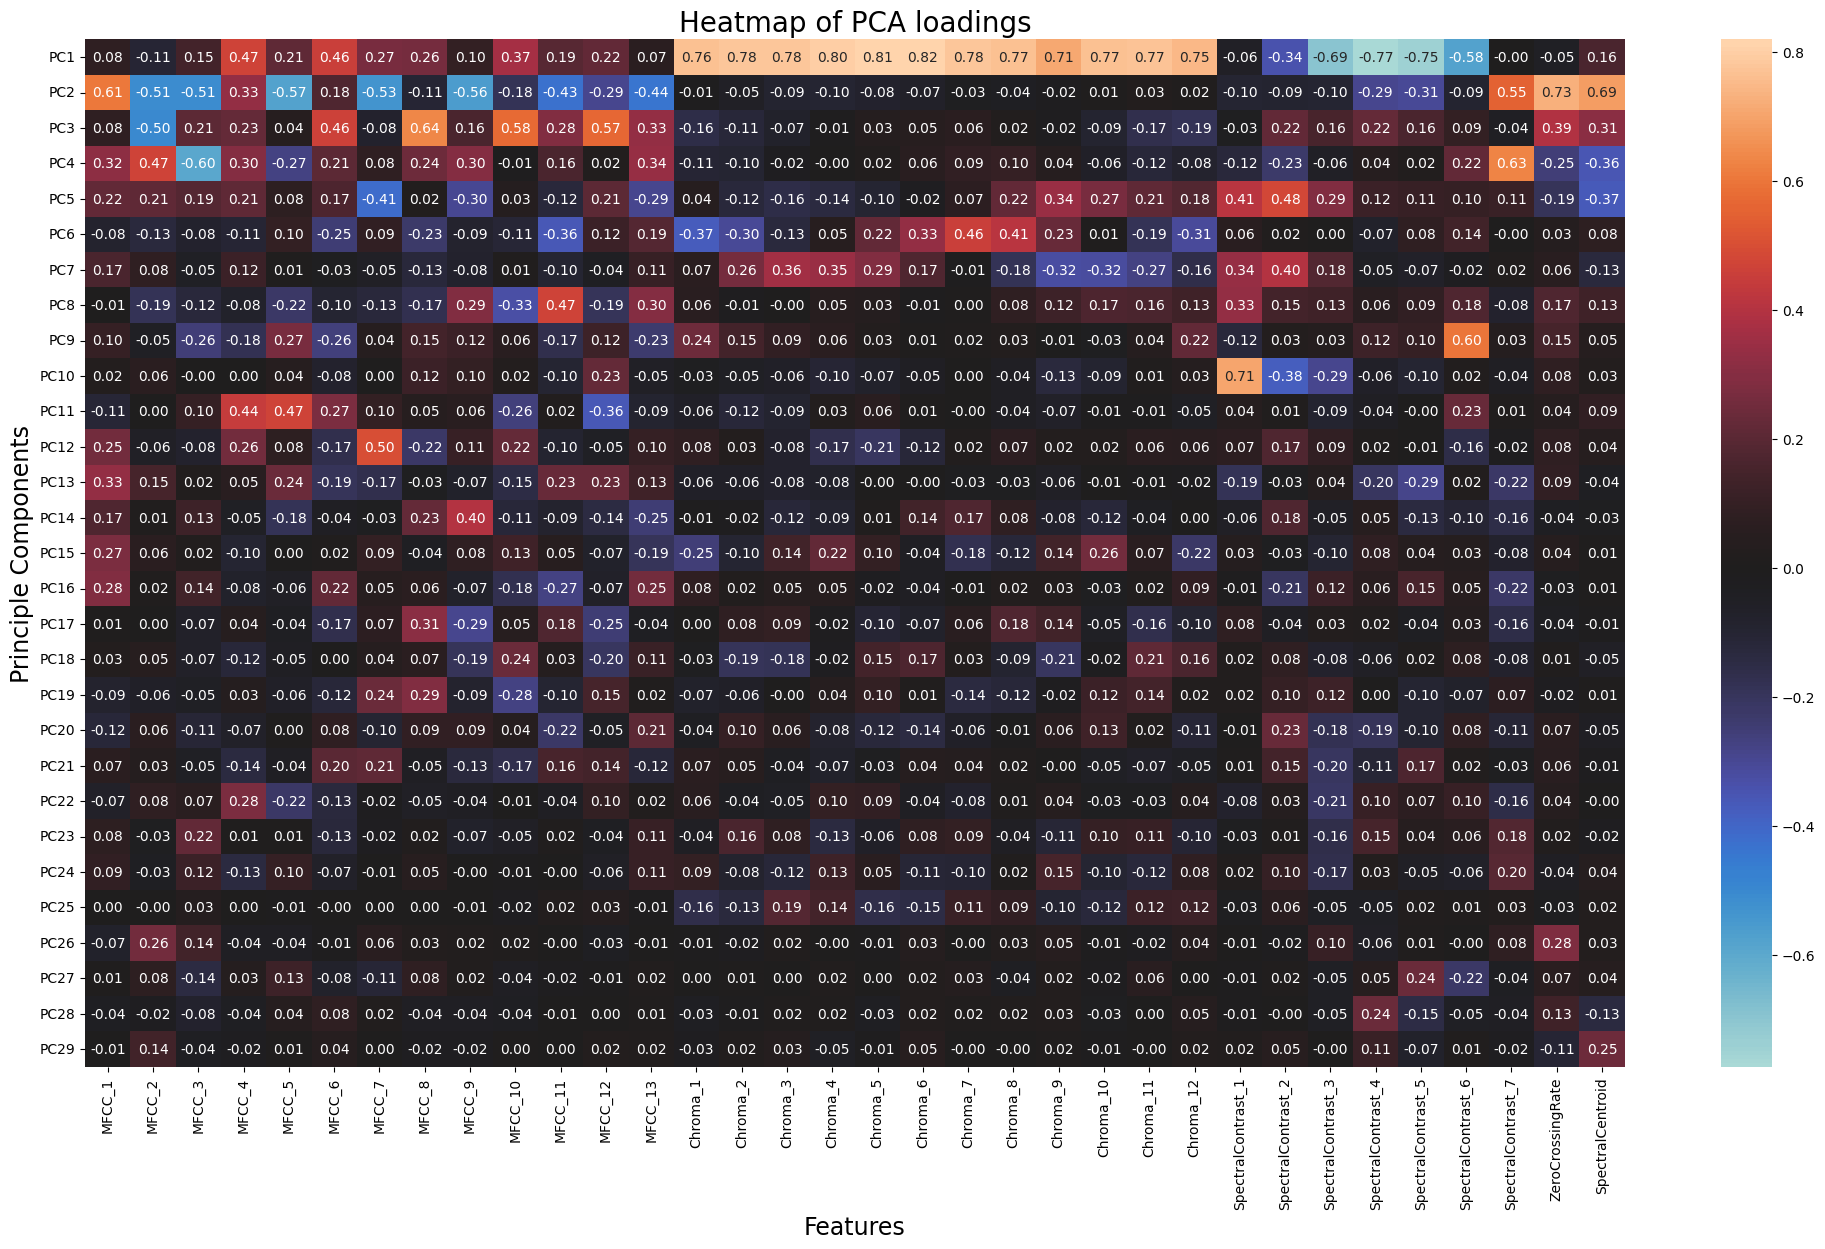

In [30]:
plt.figure(figsize=(20,12))
sns.heatmap(loading_df,cmap="icefire",center=0,annot=True,fmt=".2f")
plt.tight_layout()
plt.xlabel("Features", fontdict={"fontsize":17})
plt.ylabel("Principle Components", fontdict={"fontsize":17})
plt.title("Heatmap of PCA loadings", fontdict={"fontsize":20})
plt.show()

In [31]:
train_size,train_acc,val_acc = learning_curve(
  pipe_best,x_train,y_train,train_sizes=np.linspace(0.1,1.0,10),
  cv=10,n_jobs=-1,shuffle=True,random_state=57
)

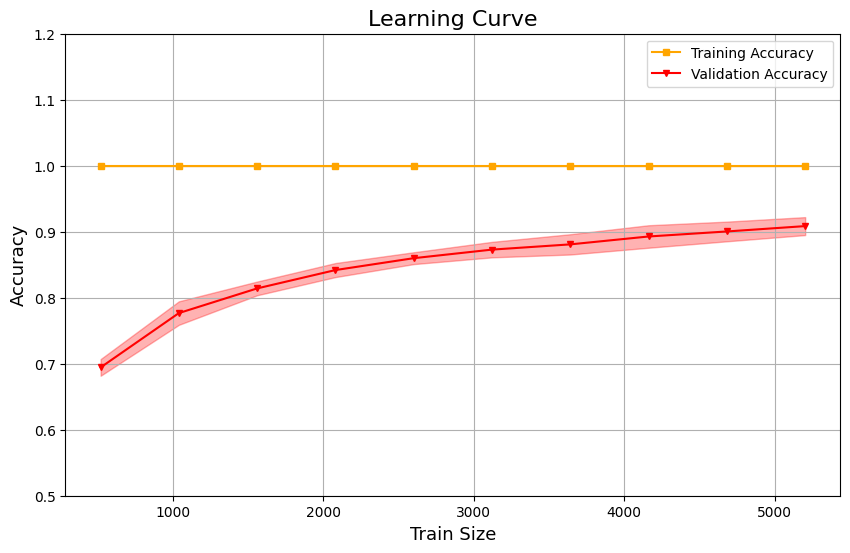

In [32]:
train_mean = np.mean(train_acc,axis=1)
train_std = np.std(train_acc,axis=1)
val_mean = np.mean(val_acc,axis=1)
val_std = np.std(val_acc,axis=1)

plt.figure(figsize=(10,6))
plt.plot(train_size,train_mean,color="orange",marker="s",markersize=4,label="Training Accuracy")
plt.fill_between(
  train_size,train_mean+train_std, train_mean-train_std, color="orange",alpha=0.3
)

plt.plot(train_size,val_mean,color="red",marker="v",markersize=4,label="Validation Accuracy")
plt.fill_between(
  train_size,val_mean+val_std,val_mean-val_std,color="red",alpha=0.3
)

plt.xlabel("Train Size", fontdict={"fontsize":13})
plt.ylabel("Accuracy", fontdict={"fontsize":13})
plt.title("Learning Curve", fontdict={"fontsize":16})
plt.legend()
plt.grid()
plt.ylim(0.5,1.2)
plt.show()